In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import gc

from datetime import datetime

sns.set(style='whitegrid')

pd.set_option('display.max_columns', None)  

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Resume

This notebook will present some exploratory analysis on the data, including distributions, correlations and information values analysis. These will be used to select some features to use in the training step.

In [2]:
# To force some binary varibles to be read as str
dtypes = \
{
    'school_year_round': str,
    'projectid': str,
    'teacher_acctid': str,                                                                              
    'school_metro': str,                                          
    'school_charter': str,                                        
    'school_magnet': str,                                                                            
    'school_nlns': str,                                            
    'school_kipp': str,                                           
    'school_charter_ready_promise': str,                           
    'teacher_prefix': str,                                        
    'teacher_teach_for_america': str,                              
    'teacher_ny_teaching_fellow': str,                                                                
    'eligible_double_your_impact_match': str,                      
    'eligible_almost_home_match': str,                                                                                                                                                      
}

In [3]:
df = pd.read_csv('../Data/Kaggle/KDDCup14/data_consolidation.csv', dtype=dtypes)

In [4]:
df.shape

(664098, 81)

In [5]:
df.columns

Index(['projectid', 'teacher_acctid', 'school_latitude', 'school_longitude',
       'school_metro', 'school_charter', 'school_magnet', 'school_year_round',
       'school_nlns', 'school_kipp', 'school_charter_ready_promise',
       'teacher_prefix', 'teacher_teach_for_america',
       'teacher_ny_teaching_fellow', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'fulfillment_labor_materials', 'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'qtd_projects', 'is_exciting', 'mean_is_exciting',
       'mean_at_least_1_teacher_referred_donor', 'mean_fully_funded',
       'mean_at_least_1_green_donation', 'mean_great_chat',
       'mean_one_non_teacher_referred_donor_giving_100_plus',
       'mean_donation_from_thoughtf

In [6]:
# Filtering train data
df['date_posted'] = pd.to_datetime(df['date_posted'])
df = df[(df['date_posted'].dt.year > 2009) & (df['date_posted'].dt.year < 2014)]

len(df)

439599

In [7]:
df['date_posted'].min()

Timestamp('2010-01-01 00:00:00')

In [8]:
df['date_posted'].max()

Timestamp('2013-12-31 00:00:00')

### Análise Geral

#### Missing Values

In [9]:
def plotNull(df, exclude='object'):
    df = df.select_dtypes(exclude=exclude)
    df_null = df.isnull().sum() / len(df)
    df_null.sort_values(inplace=True)
    df_null.plot.barh(figsize=(10, 15), xlim=(0,1), 
                      title='Percentual of "Missing Values" (%)')

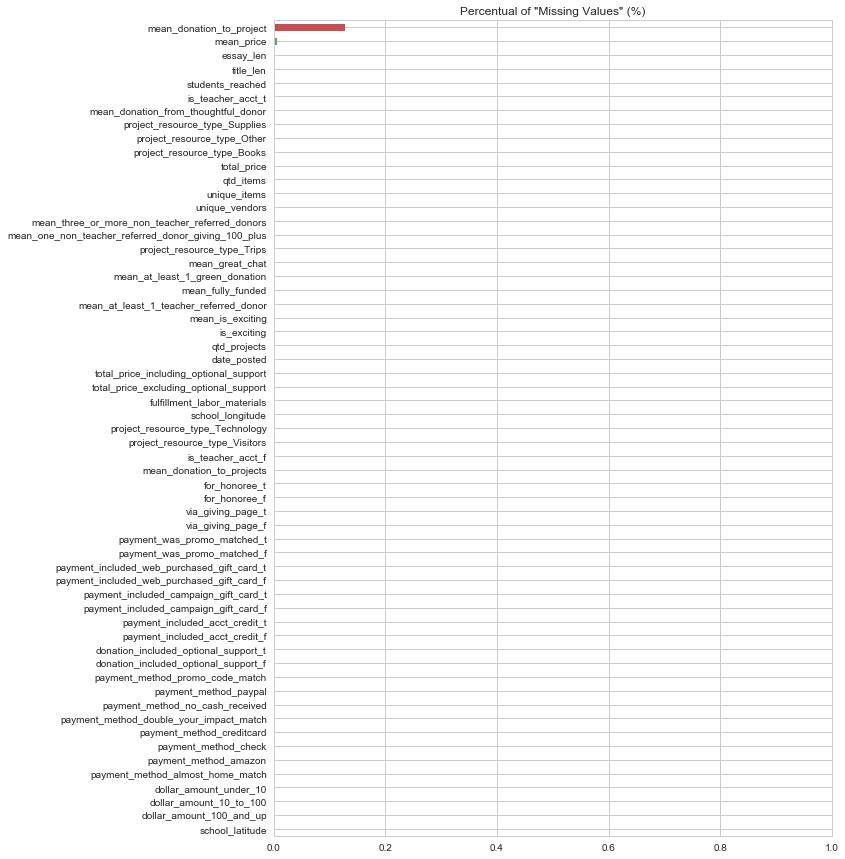

In [10]:
plotNull(df)

#### Target

In [11]:
df['is_exciting'].value_counts()

0.0    402889
1.0     36710
Name: is_exciting, dtype: int64

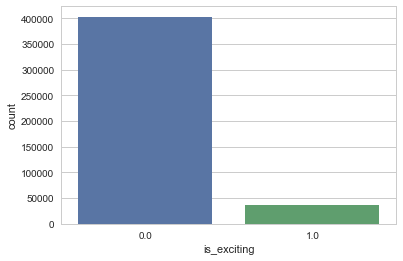

In [12]:
sns.countplot(x='is_exciting', data=df)

As can be seen, the data is unbalanced. We are going to have to deal with this is the modeling step.

### Time Analysis

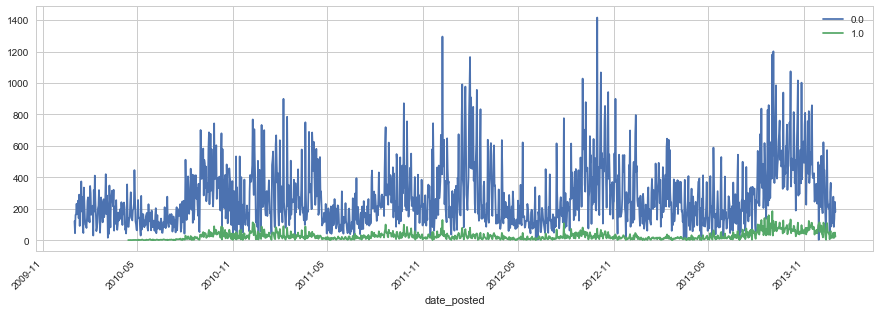

In [13]:
plt.figure(figsize=(15, 5))

for key, grp in df.groupby(['is_exciting']): 
    grp.groupby('date_posted')['projectid'].size().plot(figsize=(15, 5), rot=45, kind='line', label=key)
plt.legend();

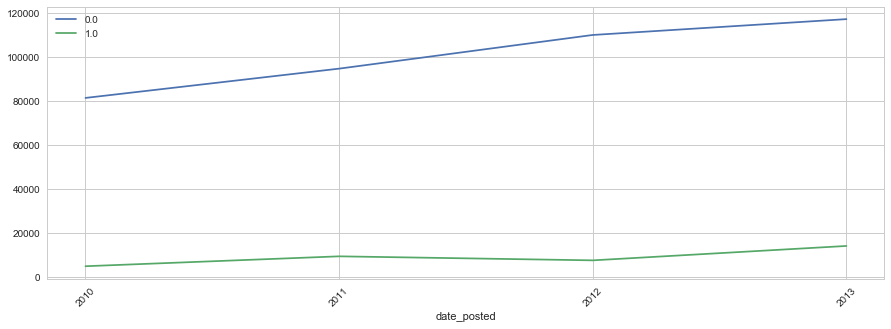

In [14]:
plt.figure(figsize=(15, 5))

per = df['date_posted'].dt.to_period("Y")
for key, grp in df.groupby(['is_exciting']): 
    grp.groupby(per).size().plot(figsize=(15, 5), rot=45, kind='line', label=key)
plt.legend();

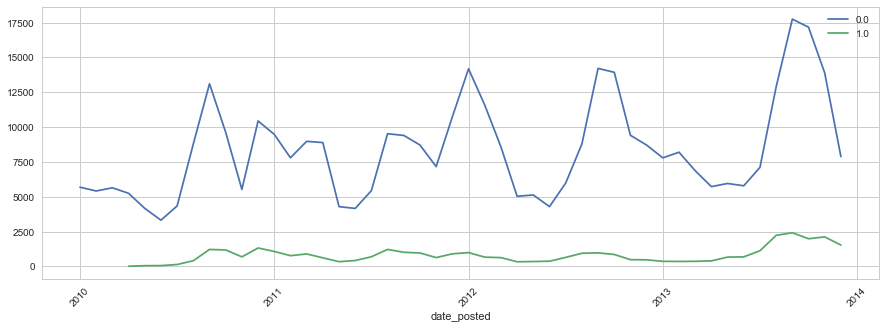

In [15]:
plt.figure(figsize=(15, 5))

per = df['date_posted'].dt.to_period("M")
for key, grp in df.groupby(['is_exciting']): 
    grp.groupby(per).size().plot(figsize=(15, 5), rot=45, kind='line', label=key)
plt.legend();

It seems that the month has some relation to the target value. For instance, looking at these plot it seems to me that at the beginning of the american year the chances of a project be considered excited is higher. Also, more projects are submitted in the beginning of the year. Given that, I'll include the month as a categorical variable.

In [16]:
df['month'] = df['date_posted'].dt.month
df['month'] = df['month'].astype(str)

### Distributions

Firstly, I'll analyse some of the features created before. After that, I'll check the distributions of some of the categorical variables. I'll not look into all of them due to the time limits and high number of features. Instead, in the next step I'll perform some analyses to discard irrelevant features.

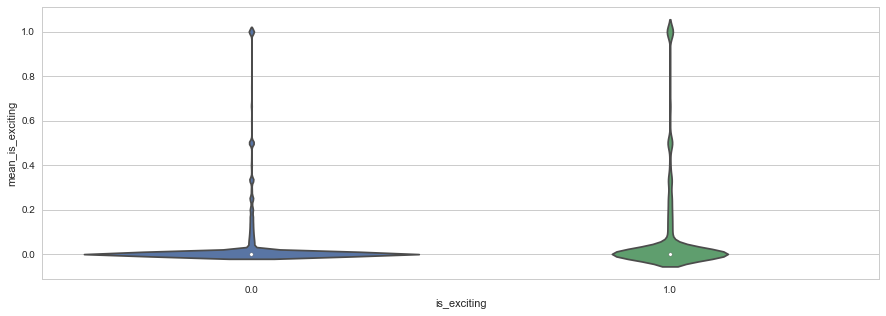

In [17]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_is_exciting', x='is_exciting', data=df)

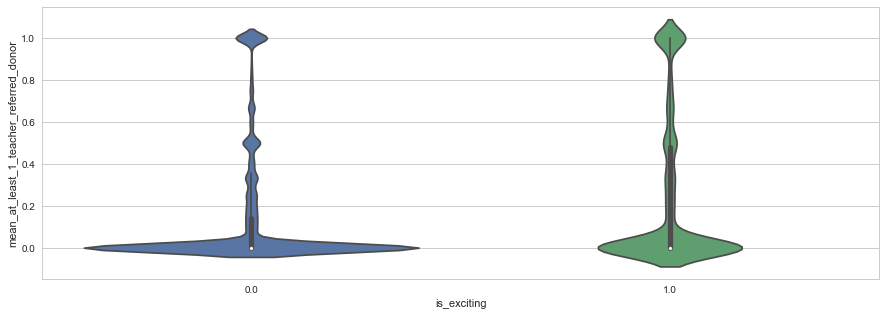

In [18]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_at_least_1_teacher_referred_donor', x='is_exciting', data=df)

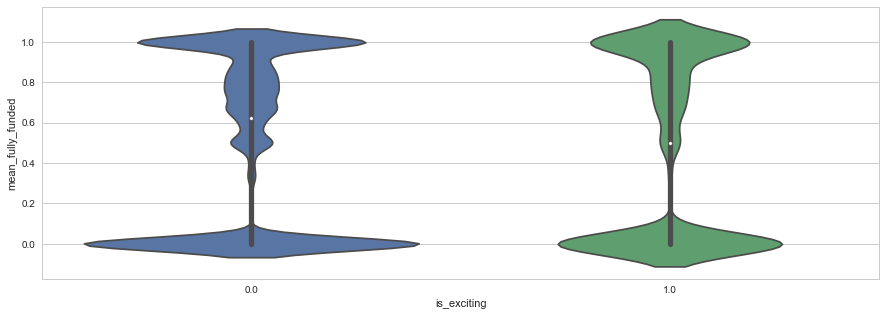

In [19]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_fully_funded', x='is_exciting', data=df)

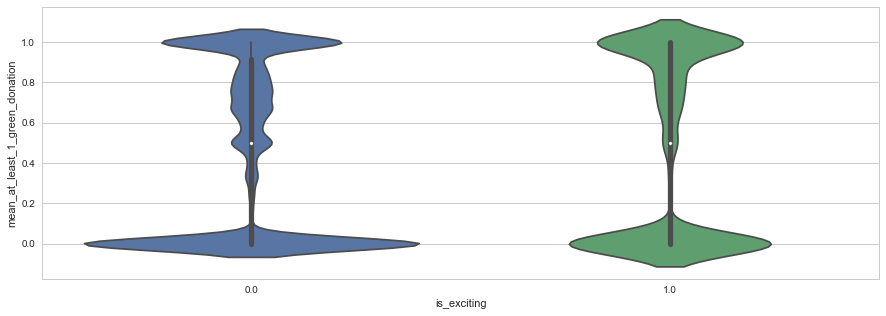

In [20]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_at_least_1_green_donation', x='is_exciting', data=df)

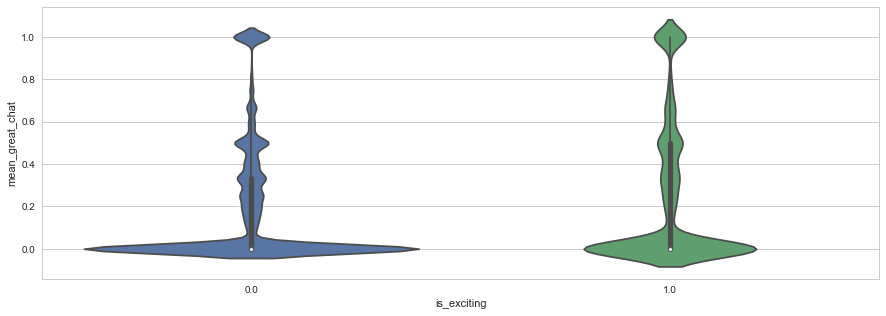

In [21]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_great_chat', x='is_exciting', data=df)

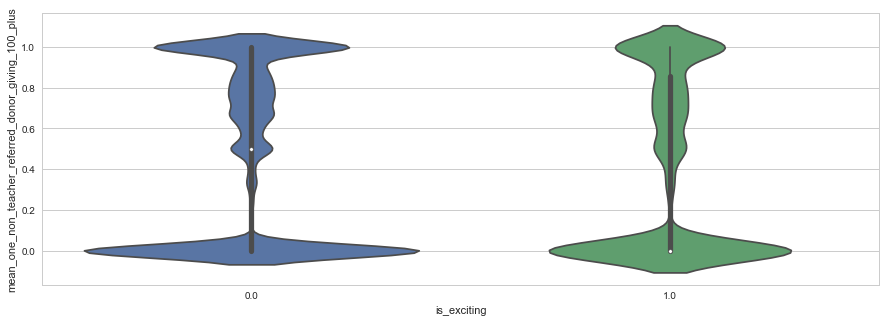

In [22]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_one_non_teacher_referred_donor_giving_100_plus', x='is_exciting', data=df)

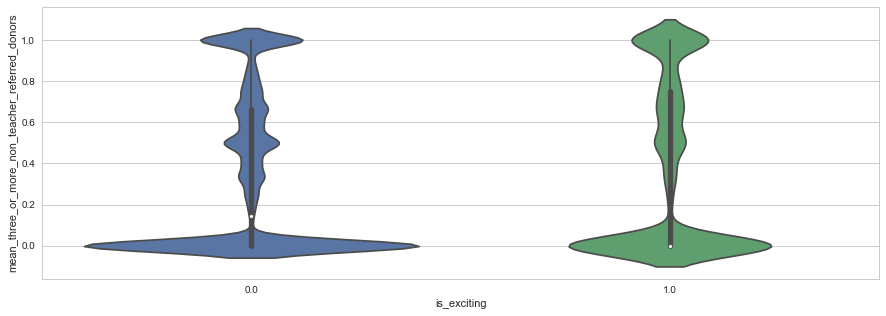

In [23]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_three_or_more_non_teacher_referred_donors', x='is_exciting', data=df)

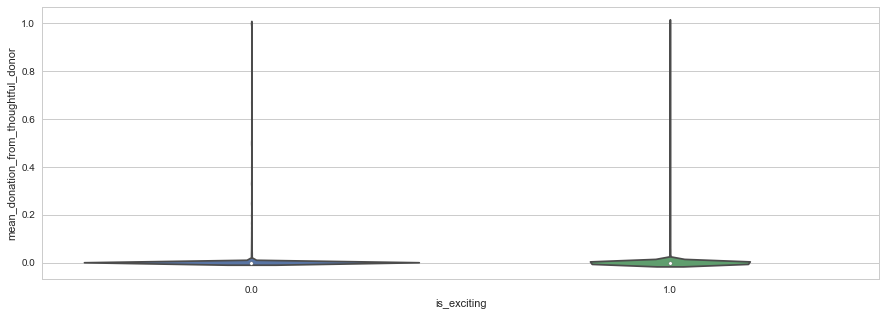

In [24]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_donation_from_thoughtful_donor', x='is_exciting', data=df)

So far, it seems to me that the created features are not helping us to distinguish between a project considered excited or not. All distributions seems similar, except that there are more projects considered not exciting than exciting.

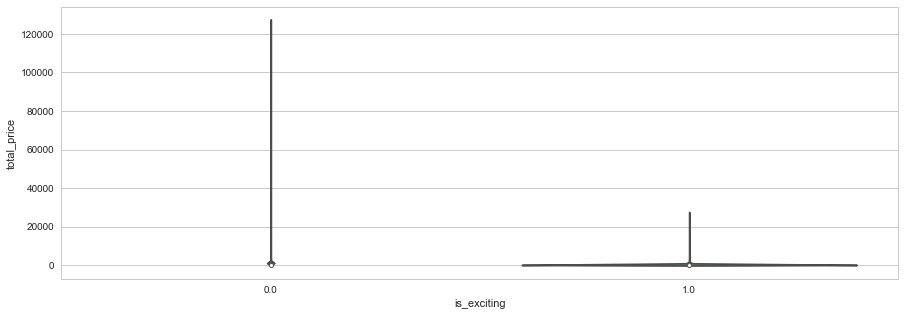

In [25]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='total_price', x='is_exciting', data=df)

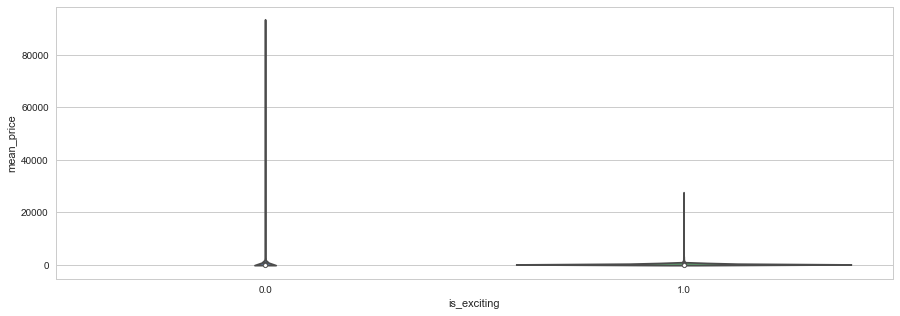

In [26]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_price', x='is_exciting', data=df)

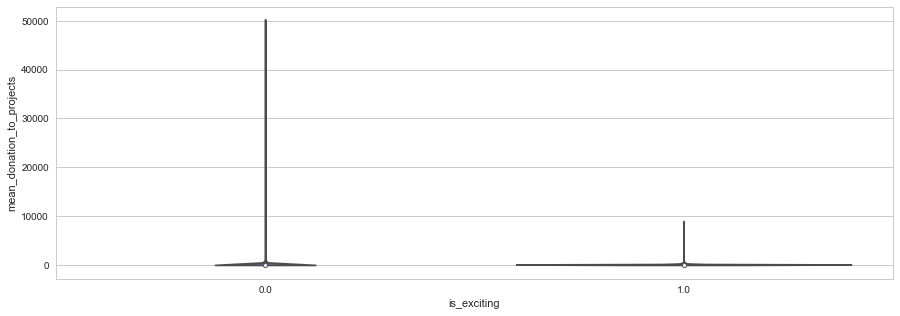

In [27]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_donation_to_projects', x='is_exciting', data=df)

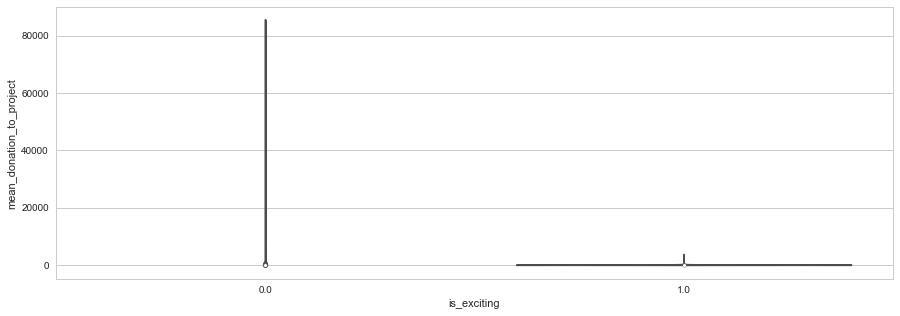

In [28]:
plt.figure(figsize=(15, 5))
sns.violinplot(y='mean_donation_to_project', x='is_exciting', data=df)

These features above are centered around zero, with some outliers, specially for the non-exciting projects. Nothing that seems really useful to differ between the targets.

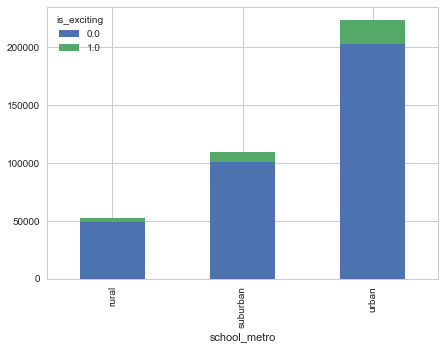

In [29]:
crosstab = pd.crosstab(df['school_metro'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

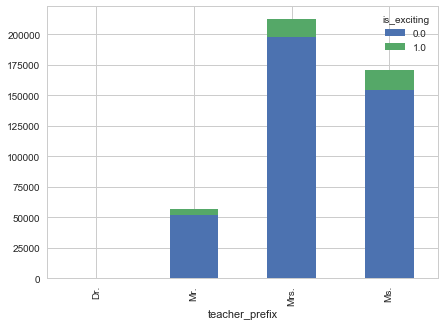

In [30]:
crosstab = pd.crosstab(df['teacher_prefix'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

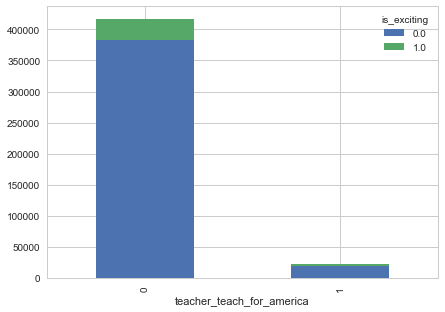

In [31]:
crosstab = pd.crosstab(df['teacher_teach_for_america'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

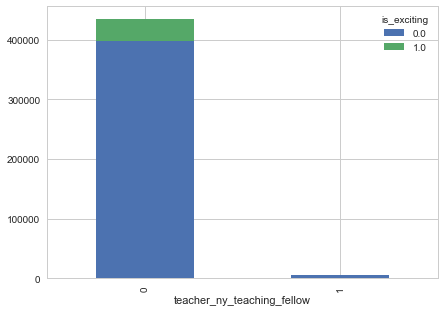

In [32]:
crosstab = pd.crosstab(df['teacher_ny_teaching_fellow'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

In [33]:
df[df['is_exciting' ] == 1]['teacher_ny_teaching_fellow'].value_counts()

0    36147
1      563
Name: teacher_ny_teaching_fellow, dtype: int64

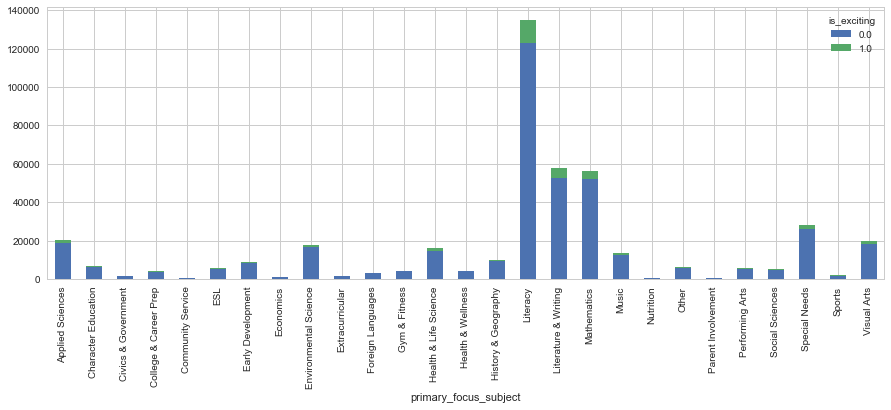

In [34]:
crosstab = pd.crosstab(df['primary_focus_subject'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

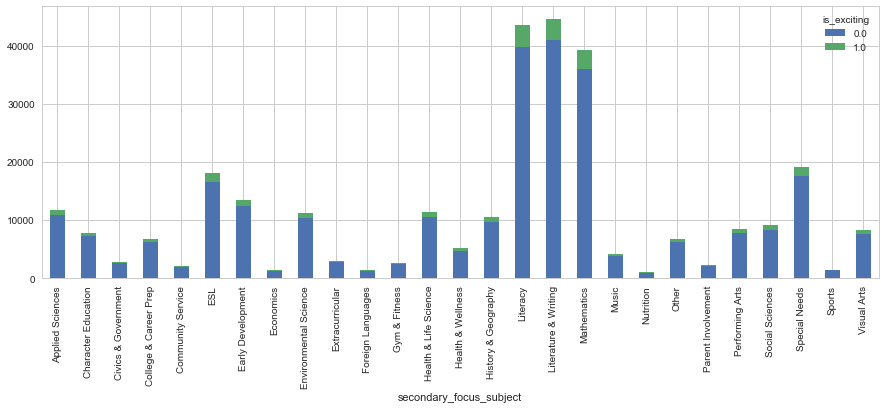

In [35]:
crosstab = pd.crosstab(df['secondary_focus_subject'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

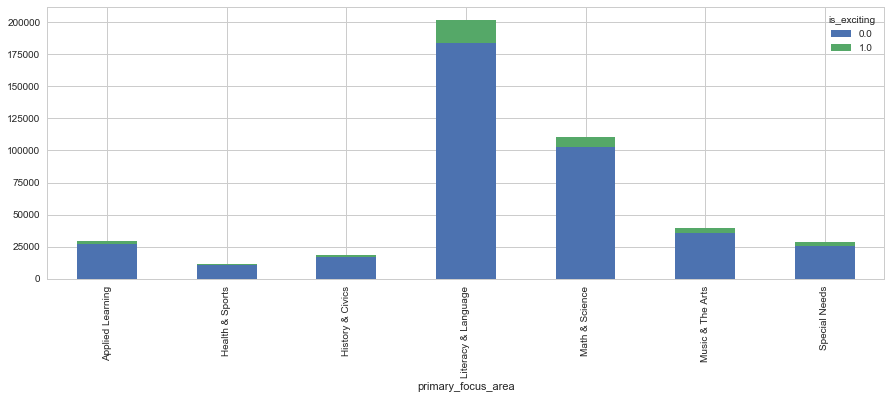

In [36]:
crosstab = pd.crosstab(df['primary_focus_area'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

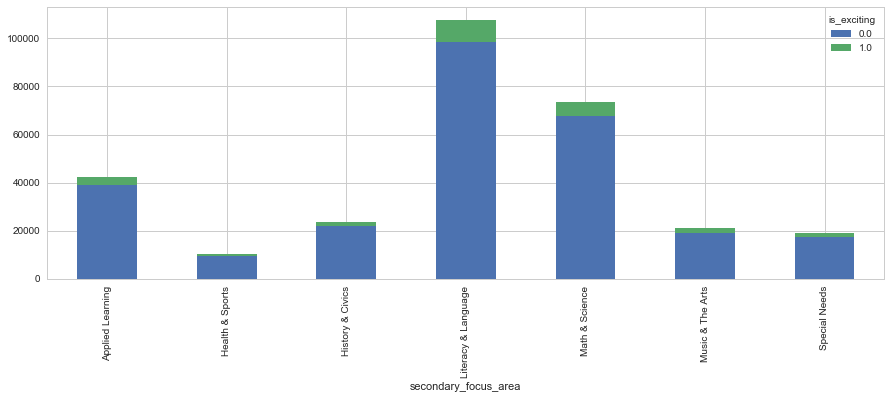

In [37]:
crosstab = pd.crosstab(df['secondary_focus_area'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

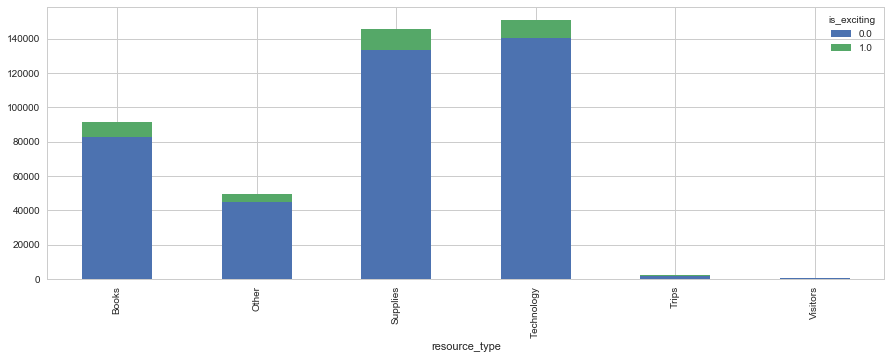

In [38]:
crosstab = pd.crosstab(df['resource_type'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

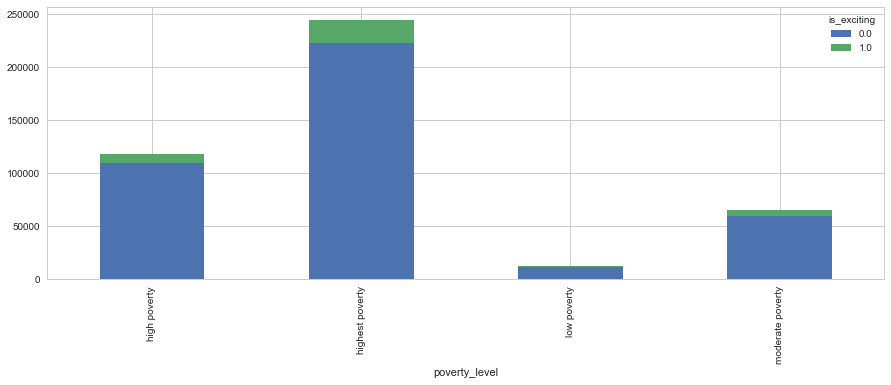

In [39]:
crosstab = pd.crosstab(df['poverty_level'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

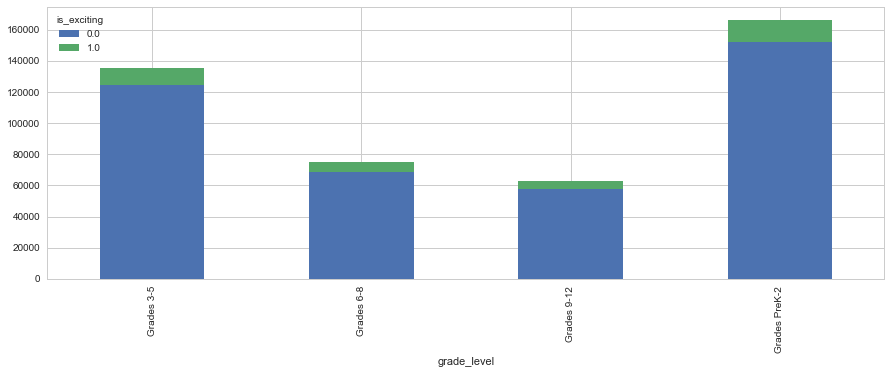

In [40]:
crosstab = pd.crosstab(df['grade_level'], df['is_exciting'])
crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

Through the plots above we can better understand the data. For example, most of the projects come from schools in region of high poverty. The most required resource is of the type technology, followed by supplies. Books appears just in the third position. Also, the majority of the projects are related to literacy & language, and not with science or culture.

### Correlation

#### Between Numerical Features

Now I'll perform some correlation analysis, both between the features and between the features and the target.

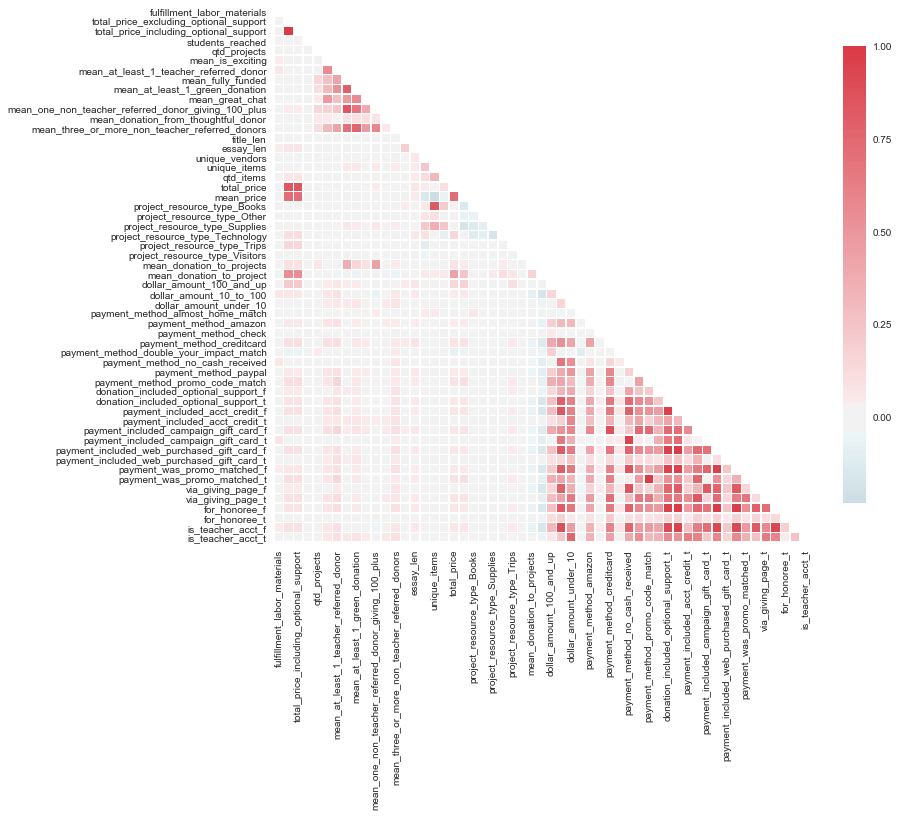

In [41]:
corr = df.select_dtypes(include=[np.number]).drop(['school_latitude', 'school_longitude', 'is_exciting'], axis=1).corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12, 12))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7});

The plot above shows the correlation between features. We can see a small triangle where high correlations appears. It's not useful to have high correlated features in the model, as at least they are not going to bring any new information. To deal with this, we could run PCA for dimension reduction, some model for selecting features (Lasso, Random Forest) or just discart one of the features in each pair in the high correlated ones. I'll go with the last option. If I had more time, I would try the others too, but that's not the case.

In [41]:
indices = np.where(abs(corr) >= 0.8)
indices = [(corr.index[x], corr.columns[y], corr.iloc[x, y]) \
           for x, y in zip(*indices) if x != y and x < y]

In [42]:
for i in indices:
    print(i)

('total_price_excluding_optional_support', 'total_price_including_optional_support', 0.99993364232689952)
('total_price_excluding_optional_support', 'total_price', 0.84919654887820761)
('total_price_including_optional_support', 'total_price', 0.84925892467356201)
('mean_fully_funded', 'mean_one_non_teacher_referred_donor_giving_100_plus', 0.84587106053830508)
('unique_items', 'project_resource_type_Books', 0.82177283355304975)
('dollar_amount_10_to_100', 'donation_included_optional_support_t', 0.80991252989267193)
('dollar_amount_10_to_100', 'payment_included_acct_credit_f', 0.8464564114422477)
('dollar_amount_10_to_100', 'payment_included_web_purchased_gift_card_f', 0.82178959400886764)
('dollar_amount_10_to_100', 'payment_was_promo_matched_f', 0.8098491210363048)
('dollar_amount_10_to_100', 'for_honoree_f', 0.81689852798438256)
('dollar_amount_10_to_100', 'is_teacher_acct_f', 0.88218747433264655)
('payment_method_creditcard', 'payment_included_campaign_gift_card_f', 0.875593513082212

#### Between Numerical Features and Target

In [43]:
from scipy import stats

X = df.select_dtypes(include=[np.number]).drop(['school_latitude', 'school_longitude', 'is_exciting'], axis=1)
y = df['is_exciting']

corr_df = pd.DataFrame(columns=['Point Biserial Correlation'])

for c in X.columns:
    corr_df.loc[c] = stats.pointbiserialr(X[c].fillna(0), y).correlation

Here we can see the correlation between each feature and the target. I used the Point Biserial Correlation because the target is dichotomous. This correlation measure also goes from -1 to 1. I'll not use this to discard any variable, specially because what are being measure is the linear correlation among features and, whilst this can be low, non-linear dimensional correlation may exist.

In [44]:
corr_df.sort_values(by='Point Biserial Correlation', ascending=False)

,Point Biserial Correlation
payment_method_creditcard,0.296407
payment_included_campaign_gift_card_f,0.245664
payment_method_paypal,0.238346
payment_was_promo_matched_f,0.219152
donation_included_optional_support_t,0.210667
dollar_amount_10_to_100,0.207368
payment_included_acct_credit_f,0.205915
for_honoree_f,0.205312
is_teacher_acct_f,0.204773
payment_included_web_purchased_gift_card_f,0.204512


### Information Value

Finally, here I'll analyse the [information value](http://ucanalytics.com/blogs/information-value-and-weight-of-evidencebanking-case/) of each categorical feature:

| IV  | Predictive Power |
| ------------- | ------------- |
| < 0.02  | Useless for prediction  |
| 0.02 to 0.1 | Weak predictor  |
| 0.1 to 0.3 | Medium predictor  |
| 0.3 to 0.5 | Strong predictor  |
| > 0.5 | Suspicious or to good to be true  |

In [42]:
from sklearn.preprocessing import LabelEncoder

categorical = list(df.select_dtypes(include=[object]).columns)
exclude = ['projectid', 'teacher_acctid', 'short_description']

to_consider = [cat for cat in categorical if not cat in exclude]

le = LabelEncoder()
for cat in to_consider:
        print(cat)
        df[cat] = le.fit_transform(df[cat].astype(str))
        print(le.classes_)
        print(le.transform(le.classes_))

school_metro
['nan' 'rural' 'suburban' 'urban']
[0 1 2 3]
school_charter
['0' '1']
[0 1]
school_magnet
['0' '1']
[0 1]
school_year_round
['0' '1']
[0 1]
school_nlns
['0' '1']
[0 1]
school_kipp
['0' '1']
[0 1]
school_charter_ready_promise
['0' '1']
[0 1]
teacher_prefix
['Dr.' 'Mr.' 'Mrs.' 'Ms.']
[0 1 2 3]
teacher_teach_for_america
['0' '1']
[0 1]
teacher_ny_teaching_fellow
['0' '1']
[0 1]
primary_focus_subject
['Applied Sciences' 'Character Education' 'Civics & Government'
 'College & Career Prep' 'Community Service' 'ESL' 'Early Development'
 'Economics' 'Environmental Science' 'Extracurricular' 'Foreign Languages'
 'Gym & Fitness' 'Health & Life Science' 'Health & Wellness'
 'History & Geography' 'Literacy' 'Literature & Writing' 'Mathematics'
 'Music' 'Nutrition' 'Other' 'Parent Involvement' 'Performing Arts'
 'Social Sciences' 'Special Needs' 'Sports' 'Visual Arts' 'nan']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
primary_focus_area
['Appl

In [43]:
import math
info_value = pd.DataFrame(columns=['Information Value'])

for cat in to_consider:
    df[cat].fillna(0, inplace=True)
    a = pd.pivot_table(df, values='projectid', dropna=False, index=cat, columns='is_exciting', aggfunc=len)
           
    a['DY0'] = a[0]/a[0].sum()
    a['DY1'] = a[1]/a[1].sum()
    a['DY0-DY1'] = a['DY0'] - a['DY1']
    a['WOE'] = np.log(a['DY0'] / a['DY1'])
    a['(DY0-DY1)*WOE'] = a['DY0-DY1'] * a['WOE']
    info_value.loc[cat] = [a['(DY0-DY1)*WOE'].sum()]
    
info_value.sort_values('Information Value', ascending=False)

,Information Value
month,0.071803
teacher_teach_for_america,0.048229
teacher_prefix,0.030714
school_charter,0.021810
resource_type,0.018878
school_metro,0.017998
eligible_double_your_impact_match,0.013953
eligible_almost_home_match,0.012793
primary_focus_subject,0.010984
secondary_focus_subject,0.007350


Bummer! According to this measure, we have a bunch of useless features, and just three weak predictors. I'll discard everything with `iv <= 0.01`.

### Dropping useless features

In [47]:
df = pd.read_csv('../Data/Kaggle/KDDCup14/data_consolidation.csv', dtype=dtypes)

In [48]:
# Abs of correlation matrix
corr = corr.abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

In [49]:
to_drop

['total_price_including_optional_support',
 'mean_one_non_teacher_referred_donor_giving_100_plus',
 'total_price',
 'project_resource_type_Books',
 'donation_included_optional_support_t',
 'payment_included_acct_credit_f',
 'payment_included_campaign_gift_card_f',
 'payment_included_campaign_gift_card_t',
 'payment_included_web_purchased_gift_card_f',
 'payment_was_promo_matched_f',
 'payment_was_promo_matched_t',
 'via_giving_page_f',
 'via_giving_page_t',
 'for_honoree_f',
 'is_teacher_acct_f']

In [50]:
df.drop(to_drop, axis=1, inplace=True)

In [51]:
to_drop = list(info_value[info_value['Information Value'] < 0.01].index)

In [52]:
to_drop

['school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_ny_teaching_fellow',
 'primary_focus_area',
 'secondary_focus_subject',
 'secondary_focus_area',
 'poverty_level',
 'grade_level']

In [53]:
df.drop(to_drop, axis=1, inplace=True)

In [54]:
df.columns

Index(['projectid', 'teacher_acctid', 'school_latitude', 'school_longitude',
       'school_metro', 'school_charter', 'teacher_prefix',
       'teacher_teach_for_america', 'primary_focus_subject', 'resource_type',
       'fulfillment_labor_materials', 'total_price_excluding_optional_support',
       'students_reached', 'eligible_double_your_impact_match',
       'eligible_almost_home_match', 'date_posted', 'qtd_projects',
       'is_exciting', 'mean_is_exciting',
       'mean_at_least_1_teacher_referred_donor', 'mean_fully_funded',
       'mean_at_least_1_green_donation', 'mean_great_chat',
       'mean_donation_from_thoughtful_donor',
       'mean_three_or_more_non_teacher_referred_donors', 'short_description',
       'title_len', 'essay_len', 'unique_vendors', 'unique_items', 'qtd_items',
       'mean_price', 'project_resource_type_Other',
       'project_resource_type_Supplies', 'project_resource_type_Technology',
       'project_resource_type_Trips', 'project_resource_type_Visitors

In [55]:
len(df.columns)

55

In [56]:
df.to_csv('../Data/Kaggle/KDDCup14/feature_selection.csv', index=False)